<a href="https://colab.research.google.com/github/arabporr/Signature_To_Graph/blob/main/Signature_to_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Signature to graph project

This code consists of four modules,

- in the first one we create a black and white image from the given input and turning it into skeleton image of the signature

- then using the second module, we construct a graph to represent the underlying patern of the skeleton image

- the display module which creates the plots and then show the output to us

- and lastly, the interface and run module which allowes user to upload images and config the parameters of the program


There are some parameters which one can change and make different outputs. Which are : 

- `sigma1` : The sigma value for the first gaussian filter in DoG calculations. 

- `sigma2` : The sigma value for the second gaussian filter in DoG calculations. 

- `threshold` : The threshold for which the color of a pixel will determined to be black or white.

- `h_res` : The elucidian distance (in pixles) between two adjacent nodes of the result high resolution graph.

- `h_res` : The elucidian distance (in pixles) between two adjacent nodes of the result mid resolution graph.

- `h_res` : The elucidian distance (in pixles) between two adjacent nodes of the result low resolution graph.


Before anything, we first import all the essential packages and libraries

In [1]:
import os
import warnings
import argparse
import itertools
import operator
from collections import defaultdict
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
import scipy.ndimage.filters
from scipy.ndimage import measurements
import skimage
import skimage.filters
import skimage.io
import skimage.morphology

## Module 1. Image binarizer and skeleton maker

In [2]:
#Difference of Gaussians (DoG) filter using two sigma values
def difference_of_gaussians(img, sigma1, sigma2):
    blur1 = skimage.filters.gaussian(img, sigma1)
    blur2 = skimage.filters.gaussian(img, sigma2)
    return blur2 - blur1

#Inverse image creater
def invert_image(img):
    return 1 - img

#Applying threshold to create Black and White image
def apply_threshold(img, threshold):
    return img > threshold

#Fixing small holes in black areas by applying convolutional kernel 'b' and 'same' padding
def fix_small_holes(image):
    fixed_image = np.copy(image)
    a = invert_image(image)
    b = np.matrix([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    c = scipy.signal.convolve2d(a, b, 'same')
    for index, value in np.ndenumerate(c):
        if value >= 7:
            fixed_image[index] = 0
        if value <= 1:
            fixed_image[index] = 1
    return fixed_image

#Creating a binary image using sigma1 and sigma2 for DoG filter and threshold for making black and white
def img_to_binary(img, sigma1, sigma2, threshold):
    #Applying the DoG filter 
    edge_image = invert_image(difference_of_gaussians(img, sigma1, sigma2))
    #Creating the black and white image
    binary_image = apply_threshold(edge_image, threshold)
    return binary_image

#Creating skeleton image using scikit image libarary
def binary_to_skeleton(binary_image):
    skeleton = invert_image(skimage.morphology.skeletonize(invert_image(binary_image)))
    return skeleton

## Module 2. Graph making based on the skeleton image

In [3]:
def pairwise(iterable):
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

#Finding endpoints (the points in which a line ends) and the junctions
def get_endpoints_and_junctions(skeleton):
    #calculating the number of adjacent black pixels (degree of adjacency) with kernel 'b' and 'same' padding
    a = invert_image(skeleton)
    b = np.matrix([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    c = scipy.signal.convolve2d(a, b, 'same')
    d = np.multiply(a, c)
    endpoints = []
    possible_junctions = []
    #classifying the pixels based on their degree
    for index, value in np.ndenumerate(d):
        if value > 2:
            possible_junctions.append(index)
        elif value == 1:
            endpoints.append(index)
    return endpoints, possible_junctions

def get_neighbor_points(y, x):
    result = list()
    result.append((y - 1, x - 1))
    result.append((y - 1, x))
    result.append((y - 1, x + 1))
    result.append((y, x - 1))
    result.append((y, x + 1))
    result.append((y + 1, x - 1))
    result.append((y + 1, x))
    result.append((y + 1, x + 1))
    return result

#Searching around a point of an image for other black adjacent pixels and retern the first one with its euclidean distance 
def find_next_point(img, point):
    _BLACK = 0
    _WHITE = 1
    neighbor_and_distance = [(tuple(map(operator.add, point, (-1, -1))), 1.41),
                             (tuple(map(operator.add, point, (-1, 0))), 1.0),
                             (tuple(map(operator.add, point, (-1, 1))), 1.41),
                             (tuple(map(operator.add, point, (0, 1))), 1.0),
                             (tuple(map(operator.add, point, (1, 1))), 1.41),
                             (tuple(map(operator.add, point, (1, 0))), 1.0),
                             (tuple(map(operator.add, point, (1, -1))), 1.41),
                             (tuple(map(operator.add, point, (0, -1))), 1.0)]
    for neighbor, distance in neighbor_and_distance:
        try:
            if img[neighbor] == _BLACK:
                return neighbor, distance
        except IndexError:
            pass
    else:
        return point, 0

#Here we traverse the image and construct the nodes and edges of our graph (the pathways)
def find_path(img, start_point, step_length):
    _BLACK = 0
    _WHITE = 1
    list_points = [start_point]
    current_distance = 0.0
    current_point = start_point
    img[current_point] = _WHITE
    #traversing the path containing this endpoint
    while True:
        next_point, distance = find_next_point(img, current_point)
        if not distance:
            break
        current_distance += distance
        img[next_point] = _WHITE
        current_point = next_point
        if current_distance >= step_length:
            list_points.append(current_point)
            current_distance = 0.0
    if current_point not in list_points:
        list_points.append(current_point)
    return list_points, img

#checking which group of junctions are neighbor to a point
def list_neighbor_values(img, point, count_zero=False):
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]
    result_list = list()
    for neighbor in neighbors:
        try:
            value = img[tuple(map(operator.add, point, neighbor))]
        except IndexError:
            pass
        else:
            if value or count_zero:
                result_list.append(value)
    return result_list

#creating the graph structure from skeleton image
def skeleton_to_paths(skeleton, step_length):
    _BLACK = 0
    _WHITE = 1
    endpoints, possible_junctions = get_endpoints_and_junctions(skeleton)
    #Removing junction points from image
    img_no_junctions = np.copy(skeleton)
    for junction in possible_junctions:
        img_no_junctions[junction] = _WHITE
    #Creating junction image
    junction_image = np.zeros_like(skeleton)
    for junction in possible_junctions:
        junction_image[junction] = _WHITE
    #Identifying the junction groups
    img_junction_labels, num = measurements.label(junction_image, structure=np.ones((3, 3)))
    junction_groups = [[] for x in range(num)]
    for index, value in np.ndenumerate(img_junction_labels):
        if value:
            junction_groups[value - 1].append(index)
    #Finding center of each group
    junction_points = [tuple([int(round(sum(y) / float(len(y)), 0)) for y in zip(*x)]) for x in junction_groups]
    #Finding the endpoints of paths after removing the junctions
    endpoints_temp, _ = get_endpoints_and_junctions(img_no_junctions)
    neighbor_junction = dict()
    ignore_endpoints = list()
    junction_paths = list()
    ep_other = list()
    #Classifying the endpoints based on the number of junctions aroud them
    for point in endpoints_temp:
        neighbor_values = list_neighbor_values(img_junction_labels, point, count_zero=False)
        if len(neighbor_values) == 1:
            neighbor_junction[point] = junction_points[neighbor_values[0] - 1]
        elif len(neighbor_values) == 2:
            ignore_endpoints.append(point)
            junction_paths.append([junction_points[neighbor_values[0] - 1], junction_points[neighbor_values[1] - 1]])
        else:
            ep_other.append(point)
    ep_next_to_junction = sorted(list(neighbor_junction.keys()), key=lambda element: (element[1], element[0]))
    ep_other = sorted(ep_other, key=lambda element: (element[1], element[0]))
    temp_img = np.copy(img_no_junctions)
    list_of_paths = list()
    #Construction paths from each endpoint (which we know that will cover all out graph)
    for ep in itertools.chain(ep_next_to_junction, ep_other):
        if ep not in ignore_endpoints:
            path, temp_img = find_path(img=temp_img, start_point=ep, step_length=step_length)
            if path[0] in neighbor_junction:
                path.insert(0, neighbor_junction[path[0]])
            if path[-1] in neighbor_junction:
                path.append(neighbor_junction[path[-1]])
            list_of_paths.append(path)
        else:
            temp_img[ep] = _WHITE
    list_of_paths.extend(junction_paths)
    #Find remaining areas (which are the circles)
    circles, num = measurements.label(invert_image(temp_img), structure=np.ones((3, 3)))
    if not num:
        circle_start_points = list()
    else:
        circle_start_points = [None for x in range(num)]
        for index, value in np.ndenumerate(circles):
            if value:
                cur_point = circle_start_points[value - 1]
                if cur_point:
                    if cur_point[1] > index[1]:
                        circle_start_points[value - 1] = index
                    if cur_point[1] == index[1]:
                        if cur_point[0] > index[0]:
                            circle_start_points[value - 1] = index
                else:
                    circle_start_points[value - 1] = index
    # Add circle paths
    for cs in circle_start_points:
        path, temp_img = find_path(img=temp_img, start_point=cs, step_length=step_length)
        # Build circle: Replace last element of path with the start element to create a circle
        path = path[:-1] + path[0:1]
        list_of_paths.append(path)
    list_of_paths = [[point for point in path if point not in ep_next_to_junction] for path in list_of_paths]
    return list_of_paths

def create_graph_from_paths(list_of_paths, **kwargs):
    # create set of nodes:
    points = sorted(list({point for path in list_of_paths for point in path}),
                    key=lambda element: (element[1], element[0]))
    node_id_to_point = {node_id: point for node_id, point in enumerate(points)}
    point_to_node_id = {point: node_id for node_id, point in node_id_to_point.items()}
    list_of_id_paths = [[point_to_node_id[point] for point in path] for path in list_of_paths]
    graph = nx.Graph(**kwargs)
    # Add all nodes
    pos_of_nodes = {node_id: (x, y) for node_id, (y, x) in node_id_to_point.items()}
    for node_id, pos in pos_of_nodes.items():
        graph.add_node(node_id, pos=pos)
    # Add all edges
    for path in list_of_id_paths:
        for v, w in pairwise(path):
            graph.add_edge(v, w)
    graph = graph.to_undirected()
    return graph

## Module 3. Showing the results and saving them

In [4]:
#We show and save our results in a 3x2 matrix of images which will create and save below
def display_graph(img, binary_image, skeleton, list_of_paths_1, list_of_paths_2, list_of_paths_3, output_name):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(20, 20),
                                                 sharex='all', sharey='all',
                                                 subplot_kw={'adjustable': 'box'})
    #plotting the original image
    ax1.imshow(img, cmap=plt.cm.gray, interpolation='none')
    ax1.axis('tight')
    ax1.set_aspect('equal')
    ax1.set_title('Original', fontsize=20)
    #plotting the binarized image
    ax2.imshow(binary_image, cmap=plt.cm.gray, interpolation='none')
    ax2.axis('tight')
    ax2.set_aspect('equal')
    ax2.set_title('Binary', fontsize=20)
    #plotting the skeleton image
    ax3.imshow(skeleton, cmap=plt.cm.gray, interpolation='none')
    ax3.axis('tight')
    ax3.set_aspect('equal')
    ax3.set_title('Skeleton', fontsize=20)
    #plotting the graph image in high Node Density (10 pixel distance between each node)
    ax4.axis('tight')
    ax4.set_aspect('equal')
    ax4.set_title('Graph High Node Density', fontsize=20)
    for path in list_of_paths_1:
        ax4.plot(*reversed(list(zip(*path))), c='b', linewidth=1)
        ax4.scatter(*reversed(list(zip(*path))), c='b', s=50)
    #plotting the graph image in middle Node Density (40 pixel distance between each node)
    ax5.axis('tight')
    ax5.set_aspect('equal')
    ax5.set_title('Graph Mid Node Density', fontsize=20)
    for path in list_of_paths_2:
        ax5.plot(*reversed(list(zip(*path))), c='b', linewidth=1)
        ax5.scatter(*reversed(list(zip(*path))), c='b', s=50)
    #plotting the graph image in low Node Density (80 pixel distance between each node)
    ax6.axis('tight')
    ax6.set_aspect('equal')
    ax6.set_title('Graph Low Node Density', fontsize=20)
    for path in list_of_paths_3:
        ax6.plot(*reversed(list(zip(*path))), c='b', linewidth=1)
        ax6.scatter(*reversed(list(zip(*path))), c='b', s=50)
    #plotting and saving the results as an image 
    fig.tight_layout()
    plt.savefig(output_name)
    plt.show()

## Module 4. Interface to tune and work with the program

This is the block which you can give the code your input and set your desired settings to calculate and build your graph.

It is done by a function called `run`, which inputs the following parameters:

- `img_path` : The location of the input image. It is required and has no default value !

    Example : `img_path='signat.jpeg' `

- `output_name` : The name of file which you want the result saves into. It is not required and has a default value of `output.png`.
    
    Example : `output_name='MyFile.png'`

- `sigma1` : The sigma value for the first gaussian filter in DoG calculations. It is not required and has a default value of `1`.

    Example : `sigma1=2`

- `sigma2` : The sigma value for the second gaussian filter in DoG calculations. It is not required and has a default value of `30`.

    Example : `sigma2=40`

- `threshold` : The threshold for which the color of a pixel will determined to be black or white. It is not required and has a default value of `0.87`.

    Example : `threshold=0.4`

- `h_res` : The elucidian distance (in pixles) between two adjacent nodes of the result high resolution graph. Note that since we have some nodes for junctions, the distance between a junction node and a normal node can be lower ! It is not required and has a default value of `10`.

    Example : `h_res=20`

- `h_res` : The elucidian distance (in pixles) between two adjacent nodes of the result mid resolution graph. Note that since we have some nodes for junctions, the distance between a junction node and a normal node can be lower ! It is not required and has a default value of `40`.

    Example : `m_res=80`

- `h_res` : The elucidian distance (in pixles) between two adjacent nodes of the result low resolution graph. Note that since we have some nodes for junctions, the distance between a junction node and a normal node can be lower ! It is not required and has a default value of `80`.

    Example : `l_res=120`

In [5]:
def calculate(img_path, sigma1, sigma2, threshold, step_length):
    #Loading image
    with open(img_path, "rb") as f_in:
        img = skimage.io.imread(f_in, as_gray=True)
    #Binarizing the image
    binary_image = img_to_binary(img, sigma1=sigma1, sigma2=sigma2, threshold=threshold)
    binary_image = fix_small_holes(binary_image)
    #Making the skeleton image
    skeleton = binary_to_skeleton(binary_image)
    #Creating the graph
    list_of_paths = skeleton_to_paths(skeleton, step_length=step_length)
    graph = create_graph_from_paths(list_of_paths)
    return img, binary_image, skeleton, list_of_paths, graph

#Here we calculate the output for three given resolutions and then dispaly the graph and saves it in given output location
def run(img_path, output_name='output.png', sigma1=1, sigma2=30, threshold=0.87, h_res=10, m_res=40, l_res=80):
    img, binary_image, skeleton, list_of_paths_1, graph = calculate(img_path, sigma1, sigma2, threshold, step_length=h_res)
    _, _, _, list_of_paths_2, _ = calculate(img_path, sigma1, sigma2, threshold, step_length=m_res)
    _, _, _, list_of_paths_3, _ = calculate(img_path, sigma1, sigma2, threshold, step_length=l_res)
    display_graph(img, binary_image, skeleton, list_of_paths_1, list_of_paths_2, list_of_paths_3, output_name)

## Input and Testing

In [6]:
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))

Saving Screen Shot 2023-04-30 at 4.47.49 PM.png to Screen Shot 2023-04-30 at 4.47.49 PM.png


<ipython-input-3-c8086d0258f1>:107: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  img_junction_labels, num = measurements.label(junction_image, structure=np.ones((3, 3)))
<ipython-input-3-c8086d0258f1>:147: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  circles, num = measurements.label(invert_image(temp_img), structure=np.ones((3, 3)))


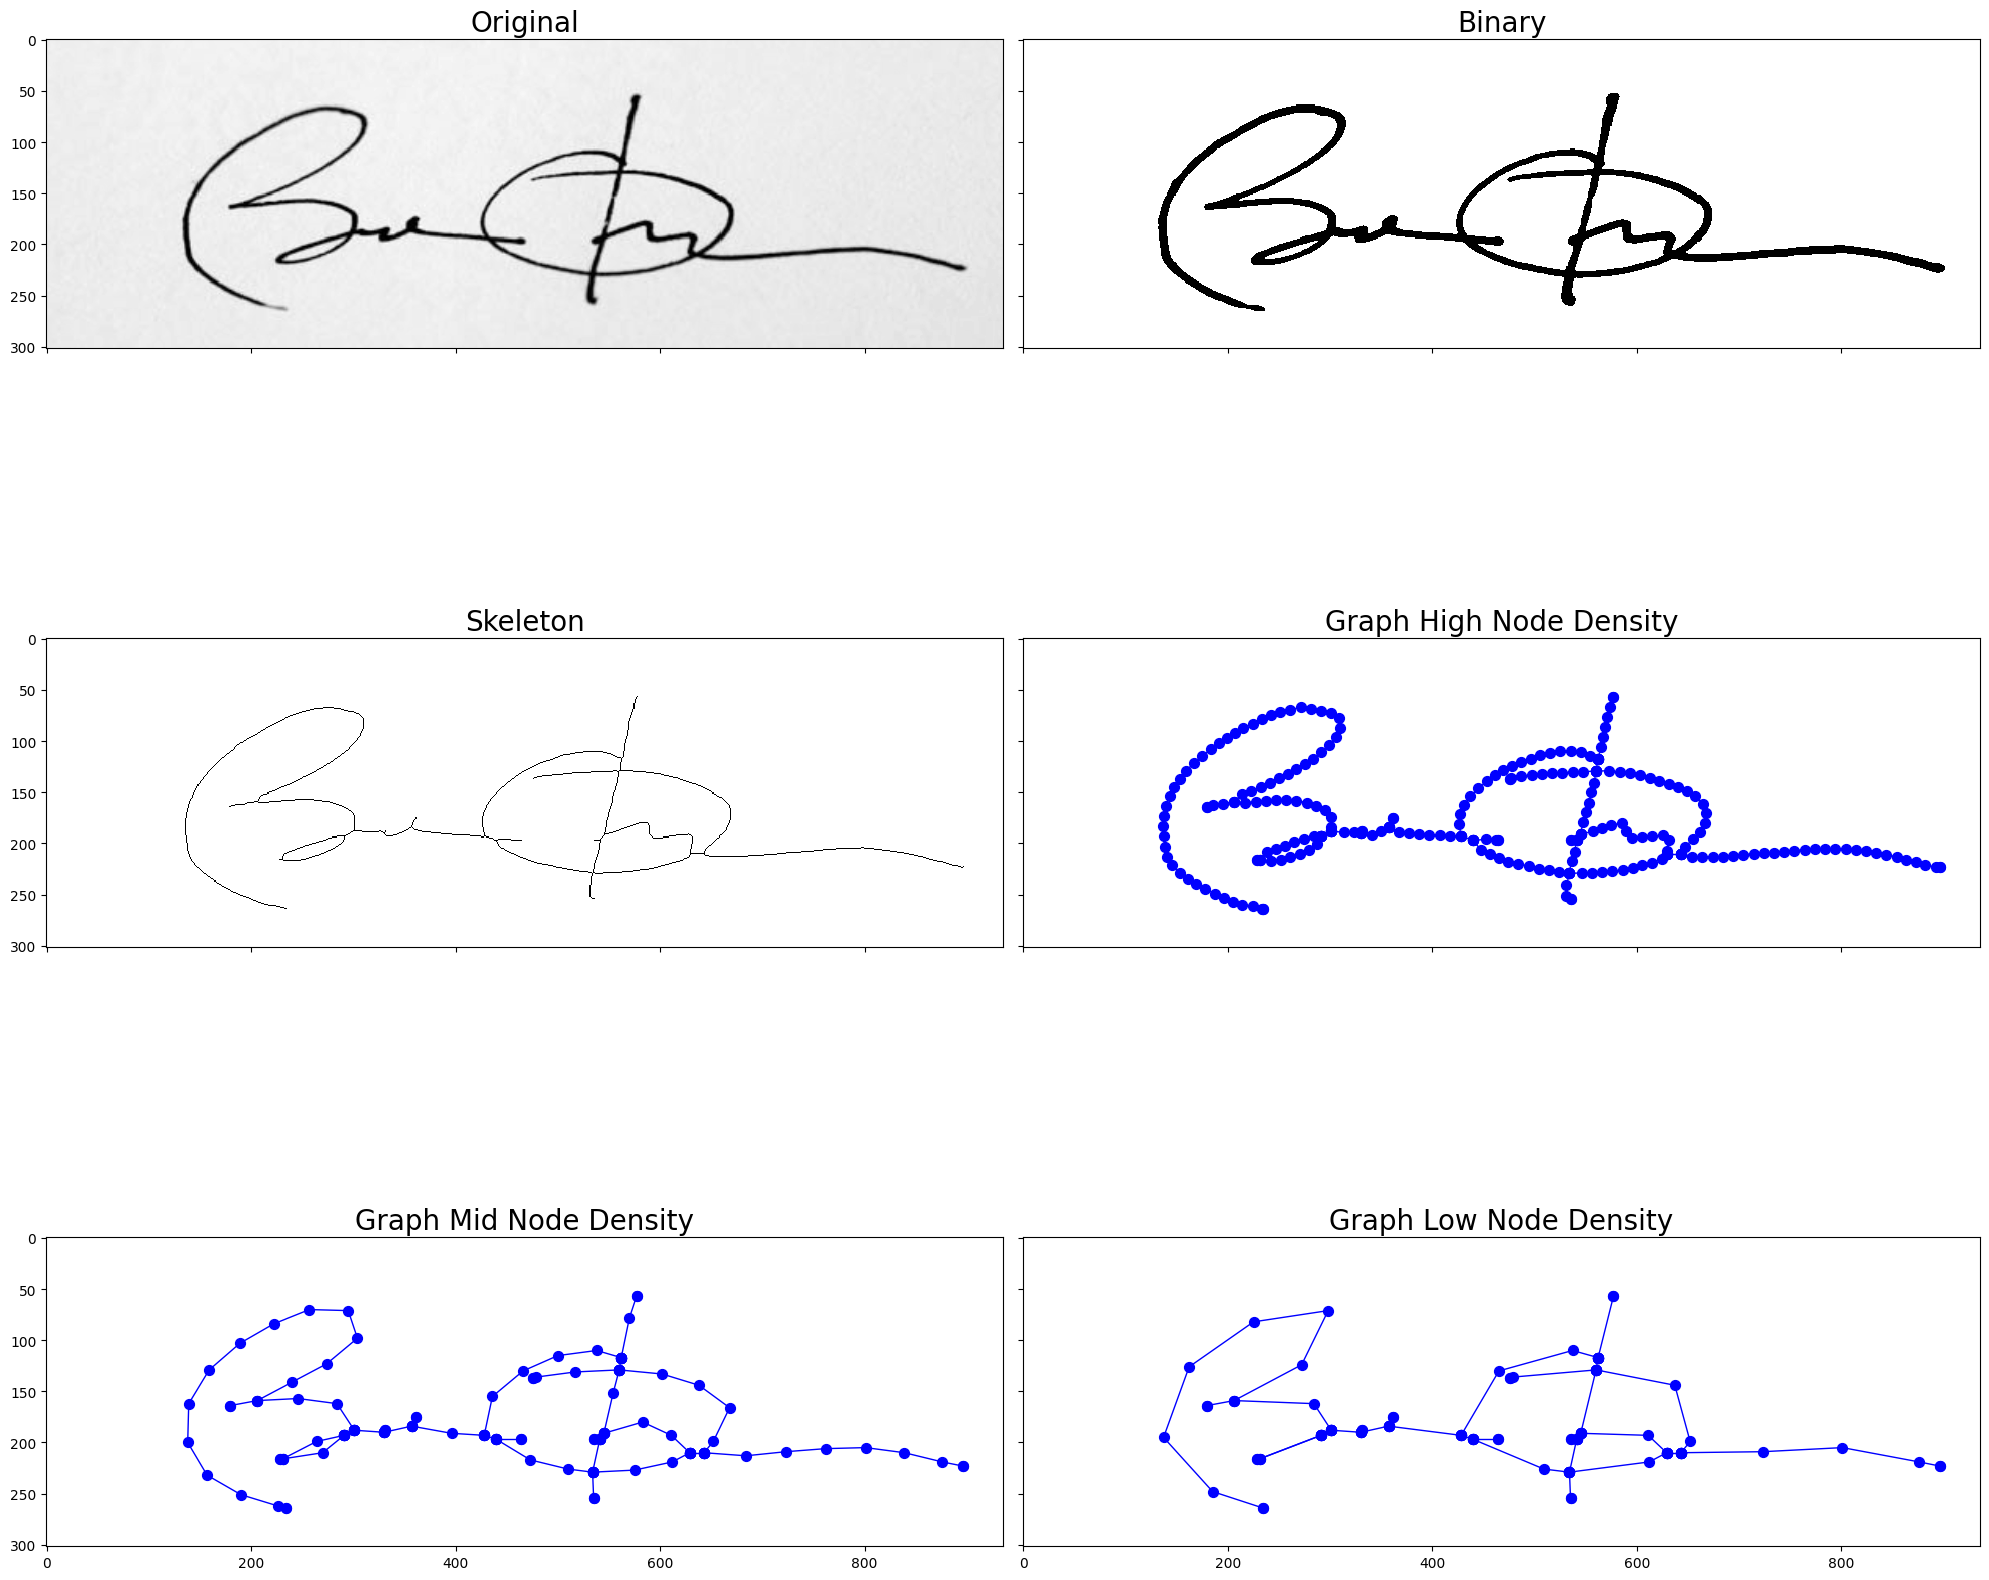

In [7]:
run(img_path=filename, output_name='sample_output.png', sigma1=1, sigma2=40, threshold=0.95)